# **Facial Emotion Detection Using CNN**

**Import Libraries**

In [28]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import keras
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, concatenate, Convolution2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools


**Load Dataset**

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
df = pd.read_csv('./fer2013/fer2013/fer2013.csv')
df.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


**Define Emotion Labels**

In [5]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts()


Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

**Preprocess Dataset**

In [6]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))


In [7]:
k.shape


(48, 48)

In [8]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])


In [9]:
X_train[0]


array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

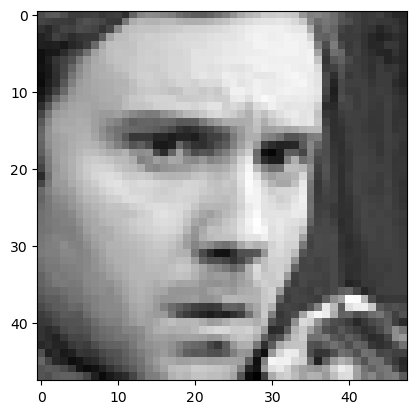

In [10]:
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')


In [11]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')


In [12]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


In [13]:
X_train.shape


(28709, 48, 48, 1)

In [14]:
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)


**Perform Image Augmentation**

In [15]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64


In [16]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)


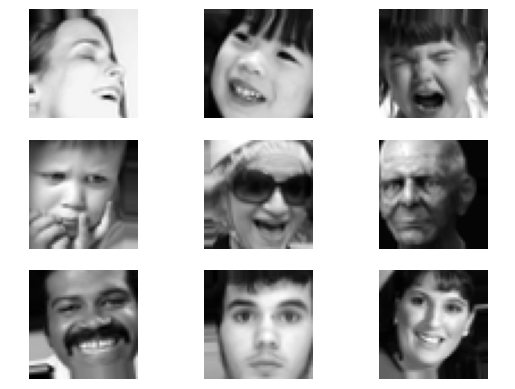

In [17]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break


**Define CNN Model**

In [18]:
def Emotion_Detection_CNN_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

     #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model


**Compile CNN Model**

In [19]:
from keras.optimizers import Adam, SGD


In [21]:
model = Emotion_Detection_CNN_Model()
opt = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_1 (MaxPooling2D)          │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1_1 (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_1 (MaxPooling2D)          │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2_1 (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_4 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,111,367 (50.02 MB)

 Trainable params: 13,103,431 (49.99 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


**Save Model Best Weights**

In [22]:
filepath="weights_min_loss.hdf5.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


**Train Model**

In [23]:
num_epochs = 100
history = model.fit(train_flow, 
                    steps_per_epoch=int(len(X_train) / batch_size), 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=test_flow,  
                    validation_steps=int(len(X_test) / batch_size))


Epoch 1/100


c:\Users\amamo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1993 - loss: 2.2185
Epoch 1: val_loss improved from inf to 1.95675, saving model to weights_min_loss.hdf5.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - accuracy: 0.1993 - loss: 2.2181 - val_accuracy: 0.1895 - val_loss: 1.9567
Epoch 2/100
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8:31 1s/step - accuracy: 0.2188 - loss: 1.8798
Epoch 2: val_loss improved from 1.95675 to 1.94856, saving model to weights_min_loss.hdf5.keras


c:\Users\amamo\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2188 - loss: 1.8798 - val_accuracy: 0.0000e+00 - val_loss: 1.9486
Epoch 3/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2405 - loss: 1.8067
Epoch 3: val_loss improved from 1.94856 to 1.87671, saving model to weights_min_loss.hdf5.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.2405 - loss: 1.8067 - val_accuracy: 0.2497 - val_loss: 1.8767
Epoch 4/100
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8:25 1s/step - accuracy: 0.2656 - loss: 1.8533
Epoch 4: val_loss improved from 1.87671 to 1.28140, saving model to weights_min_loss.hdf5.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2656 - loss: 1.8533 - val_accuracy: 0.6000 - val_loss: 1.2814
Epoch 5/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2581 - loss: 1.7735
Epoch 5: val_loss did not improve from 1.28140
448/448 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - accuracy: 0.2582 - loss: 1.7734 - val_accuracy: 0.2810 - val_loss: 1.8205
Epoch 6/100
  1/448 ━━━━━━━

**Visualize Loss and Accuracy**

<Figure size 640x480 with 0 Axes>

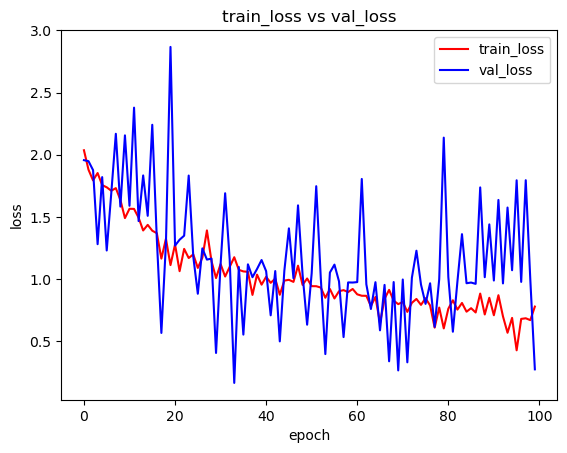

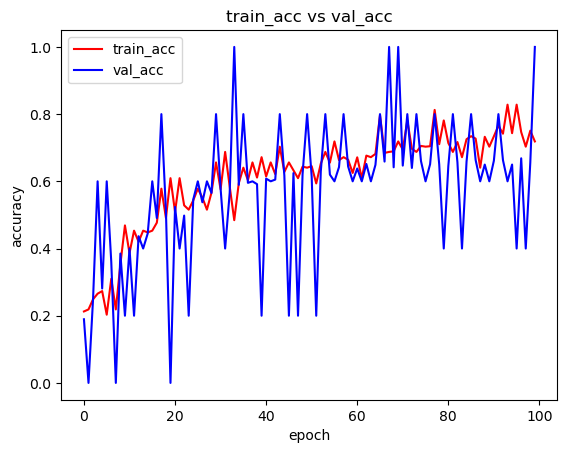

<Figure size 640x480 with 0 Axes>

In [24]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()


**Save Model**

In [25]:
model.save('./Emotion_Detection_CNN_Model.h5.keras')


**Test Model**

In [35]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.6610 - loss: 1.0010
Test Loss 0.9954827427864075
Test Acc: 0.6581220626831055


**Plot Confusion Matrix**

113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step


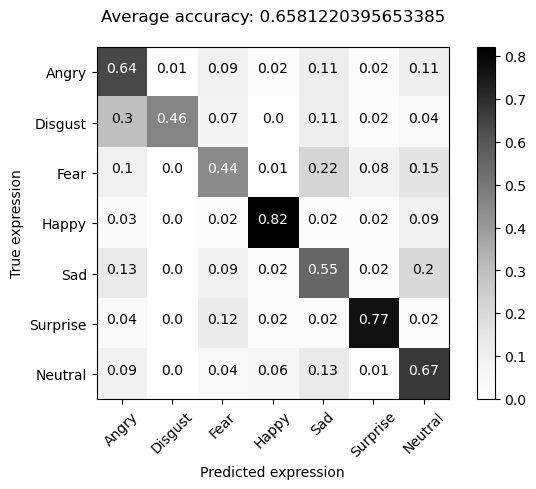

In [30]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
    
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


**Save Model**

In [34]:
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")


Saved model to disk
